# Leveraging Audio and Text Modalities in Mental Health: A Study of LLMs Performance

**Author:** Paridhi Baruah (210102061)  
**Date:** 09 May 2025

This notebook summarizes and demonstrates the key findings and methods from the research paper:  
Ali, A. A., Fouda, A. E., Hanafy, R. J., & Fouda, M. E. (2024). Leveraging Audio and Text Modalities in Mental Health: A Study of LLMs Performance. [arXiv:2412.10417]


## Motivation

Mental health disorders such as depression and PTSD are increasingly prevalent, with over one billion people affected worldwide. Traditional diagnostic methods can be subjective and slow. Large Language Models (LLMs) and multimodal approaches (combining text and audio) offer scalable, objective, and early detection possibilities. This notebook explores whether integrating audio and text modalities using LLMs can enhance the accuracy of mental health assessments, as shown in the referenced research.


## Historical Context: Multimodal Learning in Mental Health

- **Early approaches:** Focused on single modalities (text or audio) for mental health detection.
- **Recent advances:** Transformer models (BERT, GPT-4) excelled in text-based detection; wav2vec 2.0 and similar models advanced audio-based detection.
- **Multimodal fusion:** Recent studies integrate text and audio for richer context. LLMs can now process both modalities, enabling more robust and accurate assessments.
- **Key takeaway:** Combining modalities often leads to higher diagnostic accuracy than using either alone.


## The E-DAIC Dataset

- **Origin:** Enhanced version of DAIC-WOZ, designed for studying depression and PTSD via semi-clinical interviews.
- **Structure:** 275 samples, each with audio recordings, transcripts, and extracted features.
- **Labels:** Includes binary and severity labels for both depression (PHQ-8) and PTSD (PCL-C).
- **Distribution Example:**

| Disorder      | Negative | Positive |
|---------------|----------|----------|
| PHQ Binary    | 189      | 86       |
| PCL-C (PTSD)  | 188      | 87       |

- **Severity Mapping (Depression):**
    - 0-4: Minimal
    - 5-9: Mild
    - 10-14: Moderate
    - 15-19: Moderately Severe
    - 20-24: Severe


In [9]:
import pandas as pd
import re

# Example: Simulated dataset (for demonstration)
data = pd.DataFrame({
    'audio_path': ['audio1.wav', 'audio2.wav'],
    'transcript': [
        "I have been feeling sad and tired lately.",
        "I'm doing okay, just a bit stressed from work."
    ],
    'label_depression': [1, 0],  # 1 = Positive, 0 = Negative
    'label_ptsd': [0, 0]
})

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    return text.strip()

data['clean_transcript'] = data['transcript'].apply(clean_text)
data.head()


,audio_path,transcript,label_depression,label_ptsd,clean_transcript
0,audio1.wav,I have been feeling sad and tired lately.,1,0,i have been feeling sad and tired lately
1,audio2.wav,"I'm doing okay, just a bit stressed from work.",0,0,im doing okay just a bit stressed from work


In [10]:
# Example prompt for binary depression detection
def depression_prompt(transcript):
    return (f"The following transcript is from an interview: '{transcript}'. "
            "Does this person show signs of depression? Answer Yes or No.")

# Example prompt for severity classification
def depression_severity_prompt(transcript):
    return (f"The following transcript is from an interview: '{transcript}'. "
            "Classify the severity of depression into:\n"
            "0 (Minimal), 1 (Mild), 2 (Moderate), 3 (Moderately Severe), 4 (Severe). "
            "Answer with one number only.")


In [11]:
# Simulate LLM response (for demonstration)
def mock_llm_response(prompt):
    if "sad" in prompt:
        return "Yes"
    else:
        return "No"

data['llm_depression_pred'] = data['clean_transcript'].apply(lambda t: mock_llm_response(depression_prompt(t)))
data['llm_depression_pred'] = data['llm_depression_pred'].map({'Yes': 1, 'No': 0})
data.head()


,audio_path,transcript,label_depression,label_ptsd,clean_transcript,llm_depression_pred
0,audio1.wav,I have been feeling sad and tired lately.,1,0,i have been feeling sad and tired lately,1
1,audio2.wav,"I'm doing okay, just a bit stressed from work.",0,0,im doing okay just a bit stressed from work,0


In [12]:
from sklearn.metrics import balanced_accuracy_score, f1_score

y_true = data['label_depression']
y_pred = data['llm_depression_pred']

ba = balanced_accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Balanced Accuracy: {ba:.2f}")
print(f"F1 Score: {f1:.2f}")


Balanced Accuracy: 1.00
F1 Score: 1.00


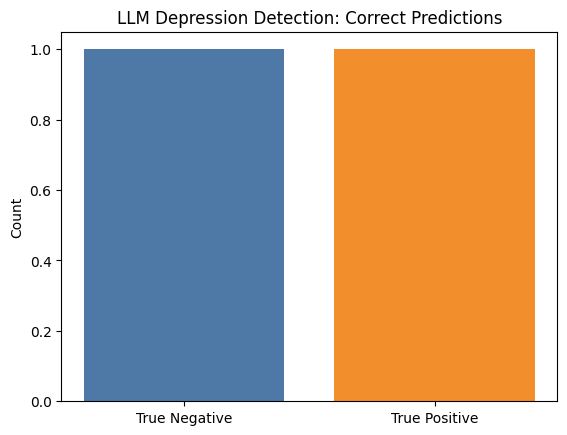

In [13]:
import matplotlib.pyplot as plt

labels = ['True Negative', 'True Positive']
counts = [((y_true == 0) & (y_pred == 0)).sum(), ((y_true == 1) & (y_pred == 1)).sum()]

plt.bar(labels, counts, color=['#4e79a7', '#f28e2b'])
plt.title("LLM Depression Detection: Correct Predictions")
plt.ylabel("Count")
plt.show()


In [14]:
import numpy as np

# Simulated predictions for demonstration
text_preds = np.array([1, 0])
audio_preds = np.array([0, 0])
combined_preds = np.array([1, 0])
true_labels = np.array([1, 0])

disagree_idx = np.where(text_preds != audio_preds)[0]
if len(disagree_idx) > 0:
    mss = ((text_preds[disagree_idx] == true_labels[disagree_idx]) & (audio_preds[disagree_idx] != true_labels[disagree_idx])).sum() \
        - ((audio_preds[disagree_idx] == true_labels[disagree_idx]) & (text_preds[disagree_idx] != true_labels[disagree_idx])).sum()
    mss = mss / len(disagree_idx)
    drs = ((combined_preds[disagree_idx] == true_labels[disagree_idx]).sum() - (combined_preds[disagree_idx] != true_labels[disagree_idx]).sum()) / len(disagree_idx)
else:
    mss = drs = 0

print(f"Modal Superiority Score (MSS): {mss:.2f}")
print(f"Disagreement Resolvement Score (DRS): {drs:.2f}")


Modal Superiority Score (MSS): 1.00
Disagreement Resolvement Score (DRS): 1.00


In [15]:
import pandas as pd

# Example: Table 6 from the paper (Binary Depression Classification, Prompt 3, Combined Modality)
results = pd.DataFrame({
    'Model': ['Gemini 1.5 Pro', 'Gemini 1.5 Flash', 'GPT-40 mini'],
    'Balanced Accuracy (%)': [77.3, 77.4, 74],
    'F1 Score': [0.67, 0.68, 0.64]
})
results


,Model,Balanced Accuracy (%),F1 Score
0,Gemini 1.5 Pro,77.3,0.67
1,Gemini 1.5 Flash,77.4,0.68
2,GPT-40 mini,74.0,0.64


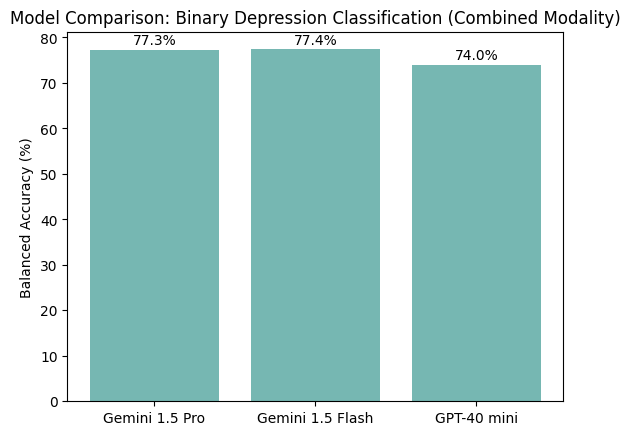

In [16]:
fig, ax = plt.subplots()
models = results['Model']
ba = results['Balanced Accuracy (%)']
f1 = results['F1 Score']

ax.bar(models, ba, color='#76b7b2', label='Balanced Accuracy (%)')
ax.set_ylabel('Balanced Accuracy (%)')
ax.set_title('Model Comparison: Binary Depression Classification (Combined Modality)')

for i, v in enumerate(ba):
    ax.text(i, v + 0.5, f"{v:.1f}%", ha='center', va='bottom')

plt.show()


## Reflections

- **Surprises:** Audio-only models sometimes performed nearly as well as text or multimodal models, showing the power of vocal cues. Prompt design can significantly affect results.
- **Scope for Improvement:** Use larger, more diverse datasets; improve long-form audio handling; standardize prompts for clinical use; add explainability to model outputs.


## References

- Ali, A. A., Fouda, A. E., Hanafy, R. J., & Fouda, M. E. (2024). Leveraging Audio and Text Modalities in Mental Health: A Study of LLMs Performance. arXiv:2412.10417
- Other works cited within this notebook, as referenced in the research paper.
